# Imports


In [ ]:
pip install surprise

In [ ]:
import pandas as pd
import ast
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from surprise import Dataset, Reader, SVD, KNNBasic, KNNWithMeans, KNNWithZScore, NMF, SlopeOne, CoClustering, BaselineOnly, NormalPredictor, SVDpp
from surprise.model_selection import train_test_split
from surprise import accuracy
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.set_option('max_colwidth',None)

#Introduction:
Here, the goal of this project is to implement Collaborative filtering algorithm on the Movies dataset which costs around 190 MB. However, when merged with four other datasets the merged dataset can be considered a "Big" data sorts of.
Also, we'll be comparing the difference between Pandas and Pyspark and how processing times in both of these methodologies change.

# Step 1: EDA and CF with Pandas
In this step, I'm doing some EDA on this dataset to explore the dataset and then implementing the collaborative filtering algorithm with Pandas which can do column wise operations.

In [ ]:
df4['id'].dtypes

dtype('float64')

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/credits.csv')
df2 = pd.read_csv('/content/drive/MyDrive/movies_metadata.csv')
df3 = pd.read_csv('/content/drive/MyDrive/ratings.csv')
df4 = pd.read_csv('/content/drive/MyDrive/links.csv')
df5 = pd.read_csv('/content/drive/MyDrive/keywords.csv')

#renaming to merge the data
df3 = df3.rename(columns={'movieId':'id'})
df4 = df4.rename(columns={'tmdbId':'id'})

#Dealing with missing/bad data
df2['id'] = pd.to_numeric(df2['id'], errors='coerce')  # Convert to numeric, invalid values become NaN
df2['id'] = df2['id'].dropna().astype(int)  # Replace NaN with -1 and convert to int
df4['id'] = df4['id'].dropna().astype(int)  # same in df2. we do this as we can't convert missing vals to int

#All ID's to int
df1['id'] = df1['id'].astype(int)
df3['id'] = df3['id'].astype(int)
#df4['id'] = df4['id'].astype(int)
df5['id'] = df5['id'].astype(int)

data = pd.merge(df1,df2,on='id',how='left')
data = pd.merge(data,df3,on='id',how='inner')
data = pd.merge(data,df4,on='id',how='inner')
data = pd.merge(data,df5,on='id',how='inner')
#print(data.columns,data.head(),

<ipython-input-5-8412193c5171>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/content/drive/MyDrive/movies_metadata.csv')


In [ ]:
data.head()
#data.info()

cast  \
0  [{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg'}, {'cast_id': 19, 'character': 'Hamm (voice)', 'credit_id': '52fe4284c3a36847f8024fa9', 'gender': 2, 'id': 7907, 'name': 'John Ratzenberger', 'order': 5, 'profile_path': '/yGechiKWL6TJDfVE2KPSJYqdMsY.jpg'}, {'cast_id': 20, 'character': 'Bo Peep (voice)', 'credit_id': '52fe4284c3a36847f8024fad', 'gender': 1, 'id': 8873, 'name': 'Annie Potts', 'order': 6, 'profile_path': '/eryXT84RL41jHSJcMy4kS3u9y6w.jpg'}, {'cast_id': 26, 'character': 'Andy (voice)', 'credit_id': '52fe4284c3a36847f8024fc1', 'gender': 0, 'id': 1116442, 'name': 'John Morris', 'order': 7, 'profile_path': '/vYGyvK4LzeaUCoNSHtsuqJUY15M.jpg'}, {'cast_id': 22, 'character': 'Sid (voice)', 'credit_id': '52fe4284c3a36847f8024fb1', 'gender': 2, 'id': 12901, 'name': 'Erik von Detten', 'order': 8, 'profile_path': '/twnF1ZaJ1FUNUuo6xLXwcxjayBE.jpg'}, {'cast_id': 23, 'character': 'Mrs. Davis (voice)', 'credit_id': '52fe4284c3a36847f8024fb5', 'gender': 1, 'id': 12133, 'name': 'Laurie Metcalf', 'order': 9, 'profile_path': '/unMMIT60eoBM2sN2nyR7EZ2BvvD.jpg'}, {'cast_id': 24, 'character': 'Sergeant (voice)', 'credit_id': '52fe4284c3a36847f8024fb9', 'gender': 2, 'id': 8655, 'name': 'R. Lee Ermey', 'order': 10, 'profile_path': '/r8GBqFBjypLUP9VVqDqfZ7wYbSs.jpg'}, {'cast_id': 25, 'character': 'Hannah (voice)', 'credit_id': '52fe4284c3a36847f8024fbd', 'gender': 1, 'id': 12903, 'name': 'Sarah Freeman', 'order': 11, 'profile_path': None}, {'cast_id': 27, 'character': 'TV Announcer (voice)', 'credit_id': '52fe4284c3a36847f8024fc5', 'gender': 2, 'id': 37221, 'name': 'Penn Jillette', 'order': 12, 'profile_path': '/zmAaXUdx12NRsssgHbk1T31j2x9.jpg'}]   
1  [{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg'}, {'cast_id': 19, 'character': 'Hamm (voice)', 'credit_id': '52fe4284c3a36847f8024fa9', 'gender': 2, 'id': 7907, 'name': 'John Ratzenberger', 'order': 5, 'profile_path': '/yGechiKWL6TJDfVE2KPSJYqdMsY.jpg'}, {'cast_id': 20, 'character': 'Bo Peep (voice)', 'credit_id': '52fe4284c3a36847f8024fad', 'gender': 1, 'id': 8873, 'name': 'A

## 1.1 Now since the data size went upto 2.7GB, the data has to be either processed in chunks or it is better to use spark for this.

In [ ]:
data.columns

Index(['cast', 'crew', 'id', 'adult', 'belongs_to_collection', 'budget',
       'genres', 'homepage', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'userId', 'rating', 'timestamp',
       'movieId', 'imdbId', 'keywords'],
      dtype='object')

In [ ]:
#Unique movies (Spoiler: basically all the movies are unique)
#umovies = data['id'].nunique()
#print(umovies)
#----
#Now, Extracting actor names from the 'cast' column
actor_names = []

for cast_list in df1['cast']:
    if pd.notnull(cast_list):
        actor_names.extend([actor['name'] for actor in eval(cast_list)])

# Convert to a set to get unique actors
unique_actors = set(actor_names)

# Display the number of unique actors and sample names
print(f"Total unique actors: {len(unique_actors)}")
#----
actor_counts = Counter(actor_names)

# Find the top 10 most frequently appearing actors
most_common_actors = actor_counts.most_common(20)

# Display the results
print("Top 10 most frequently appearing actors:")
for actor, count in most_common_actors:
    print(f"{actor}: {count} appearances")

Total unique actors: 202747
Top 10 most frequently appearing actors:
Bess Flowers: 241 appearances
Christopher Lee: 148 appearances
John Wayne: 125 appearances
Samuel L. Jackson: 123 appearances
Gérard Depardieu: 110 appearances
Michael Caine: 110 appearances
Donald Sutherland: 109 appearances
John Carradine: 109 appearances
Jackie Chan: 108 appearances
Frank Welker: 107 appearances
Robert De Niro: 104 appearances
Danny Trejo: 102 appearances
Steve Buscemi: 101 appearances
Irving Bacon: 98 appearances
John Goodman: 97 appearances
Christopher Walken: 96 appearances
Danny Glover: 96 appearances
Dennis Hopper: 94 appearances
Susan Sarandon: 93 appearances
John Hurt: 93 appearances


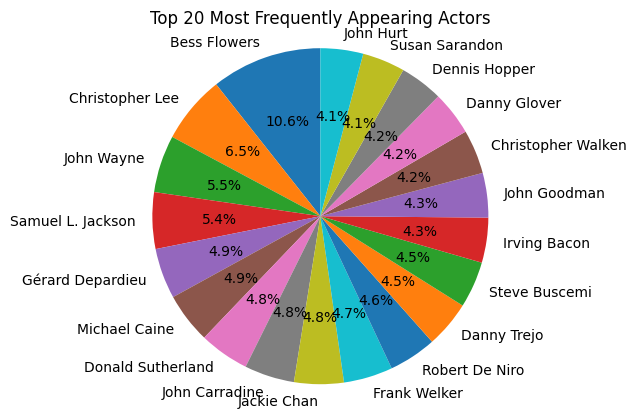

In [ ]:
# Assuming 'most_common_actors' is already defined as in your code
actors = [actor for actor, count in most_common_actors]
counts = [count for actor, count in most_common_actors]

# Create the pie chart
plt.pie(counts, labels=actors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Top 20 Most Frequently Appearing Actors')

#To see the output, run the code.
plt.show()

In [ ]:
director_names = []

# Loop through each row in the 'crew' column
for crew_list in df1['crew']:
    if pd.notnull(crew_list):  # Check if the crew list is not null
        # Filter for directors and add their names to the list
        director_names.extend(
            [member['name'] for member in eval(crew_list) if member.get('job') == 'Director']
        )

# Count occurrences of each director's name
director_counts = Counter(director_names)

# Find the top 10 most frequently appearing directors
most_common_directors = director_counts.most_common(10)

# Display the results
print("Top 10 most frequently appearing directors:")
for director, count in most_common_directors:
    print(f"{director}: {count} directions")

Top 10 most frequently appearing directors:
John Ford: 68 directions
Michael Curtiz: 65 directions
Werner Herzog: 55 directions
Alfred Hitchcock: 53 directions
Georges Méliès: 51 directions
Jean-Luc Godard: 50 directions
Woody Allen: 49 directions
Sidney Lumet: 46 directions
Charlie Chaplin: 44 directions
William A. Wellman: 43 directions


In [ ]:
#data[['genres','production_countries']]
data['genres'].dtypes

dtype('O')

In [ ]:

# Extract genre and country names
genre_country_pairs = []

# Loop through each row
for _, row in df2.iterrows():
      if pd.notnull(row['genres']) and pd.notnull(row['production_countries']):
        # Extract genres and production countries
        try:  # Add a try-except block to handle potential errors
            genres = [genre['name'] for genre in eval(row['genres'])]
            countries = [country['name'] for country in eval(row['production_countries']) if country['name'] != 'United States of America']
            # I excluded US from the above code as US topped almost every Genre so, second to US, this was the result
            if not countries:
                continue
            # Create pairs of each genre with each country
            for genre in genres:
                for country in countries:
                    genre_country_pairs.append((genre, country))
        except (TypeError, ValueError):  # Catch TypeError and ValueError
            # Handle the error, e.g., skip the row or print a message
            #print(f"Error processing row: {row.name}")  # Uncomment to print error message
            pass  # Skip the row if an error occurs
# Convert to a DataFrame for counting
genre_country_df = pd.DataFrame(genre_country_pairs, columns=['Genre', 'Country'])

# Count occurrences of each Genre-Country pair
genre_country_counts = genre_country_df.value_counts().reset_index(name='Count')

# Display the top 10 Genre-Country pairs
print("Top 10 Genre-Country combinations:")
print(genre_country_counts.head(10))

Top 10 Genre-Country combinations:
      Genre         Country  Count
0     Drama          France   2409
1     Drama  United Kingdom   2142
2     Drama         Germany   1305
3    Comedy          France   1187
4    Comedy  United Kingdom   1011
5     Drama           Italy    991
6  Thriller  United Kingdom    923
7     Drama           Japan    818
8     Drama          Canada    773
9   Romance          France    714


In [ ]:
x = [data['revenue'],data['runtime'],data['rating'],data['popularity']]

for atts in x:
  correlation = data['budget'].corr(atts)
  print(f"Correlation between budget and revenue: {correlation}")

Correlation between budget and revenue: 0.7226761112989999
Correlation between budget and revenue: 0.28749045166264164
Correlation between budget and revenue: 0.018037737150986326
Correlation between budget and revenue: 0.49072424703211365


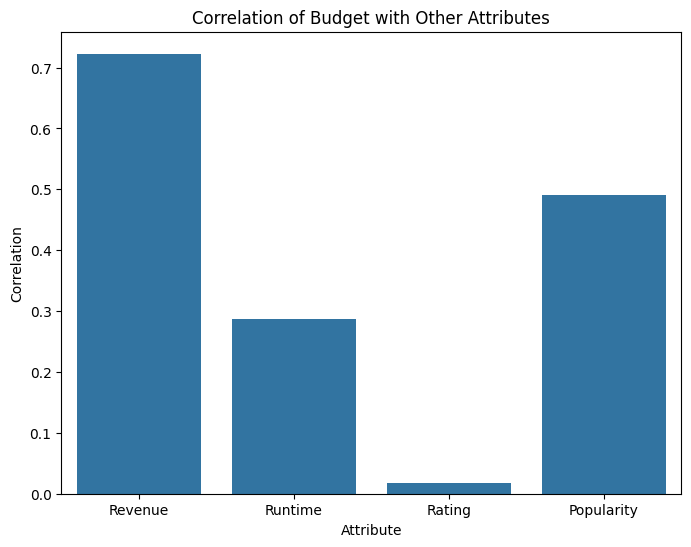

In [ ]:
# Create a list to store correlation values
correlations = []

# Calculate and store correlations
for atts in x:
    correlation = data['budget'].corr(atts)
    correlations.append(correlation)


# Create a bar plot of the correlations
plt.figure(figsize=(8, 6))
sns.barplot(x=['Revenue', 'Runtime', 'Rating', 'Popularity'], y=correlations)
plt.title('Correlation of Budget with Other Attributes')
plt.xlabel('Attribute')
plt.ylabel('Correlation')
plt.show()

Popularity and Revenue are positively related with the budget here.

<ipython-input-13-49efd1cbe550>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=language_stats_0, x='original_language', y='avg_popularity', palette="viridis")


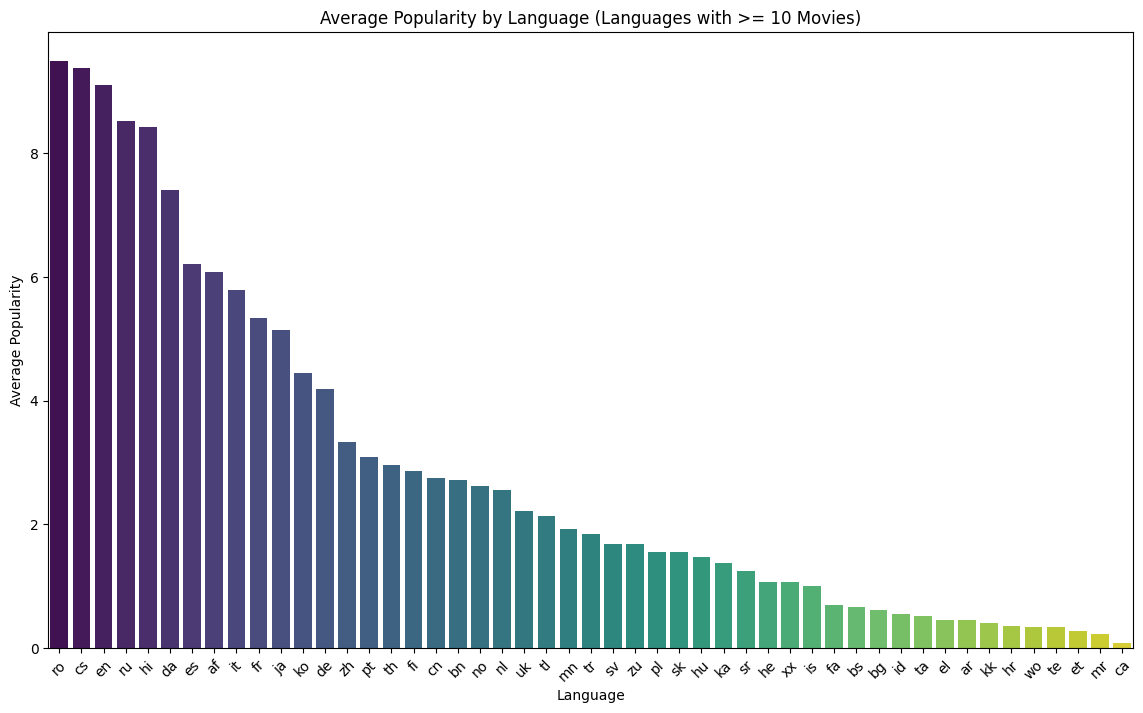

<ipython-input-13-49efd1cbe550>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=language_stats_1, x='original_language', y='avg_revenue', palette="viridis")


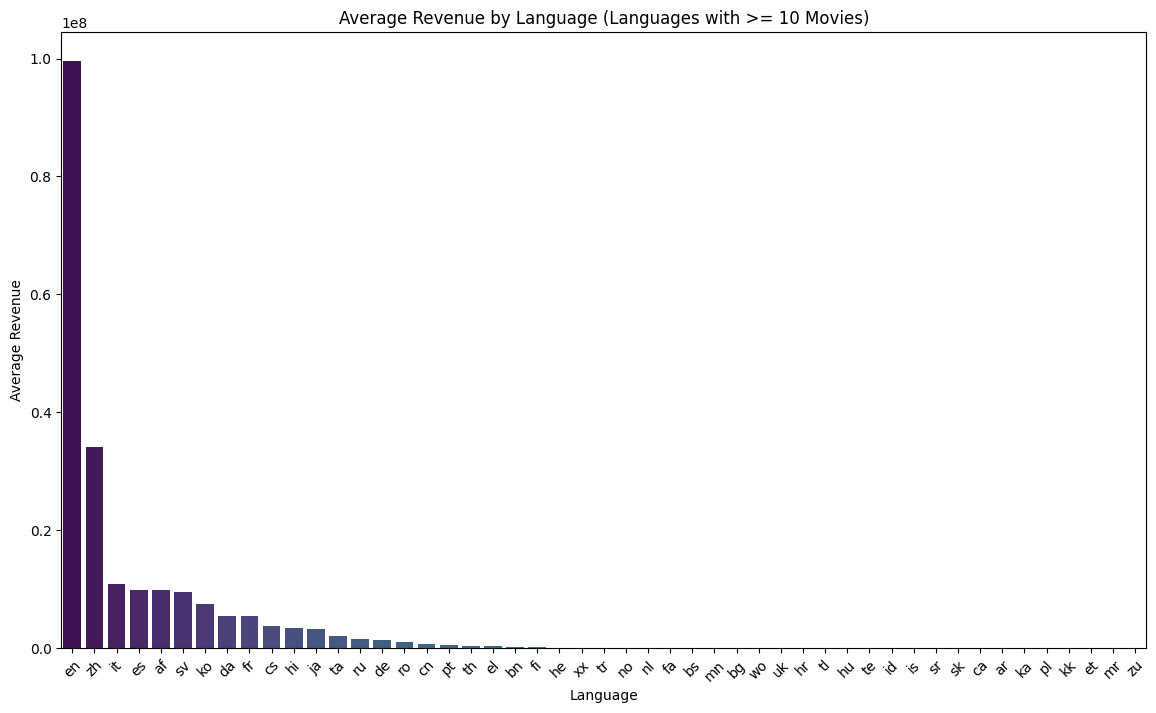

In [ ]:
# Filter out rows with missing values in 'original_language', 'popularity', or 'revenue'
filtered_df_1 = data[['original_language', 'popularity', 'revenue']].dropna()

# Convert 'popularity' and 'revenue' columns to numeric, handling errors as the data's a little bad
filtered_df_1['popularity'] = pd.to_numeric(filtered_df_1['popularity'], errors='coerce')
filtered_df_1['revenue'] = pd.to_numeric(filtered_df_1['revenue'], errors='coerce')

# Group by language and calculate average popularity and revenue
language_stats = (
    filtered_df_1.groupby('original_language')
    .agg(avg_popularity=('popularity', 'mean'), avg_revenue=('revenue', 'mean'), movie_count=('revenue', 'count'))
    .reset_index()
)

# Filter out languages with fewer than 10 movies for clearer visualization
language_stats = language_stats[language_stats['movie_count'] >= 10]

# Sort values by popularity for plotting
language_stats_0 = language_stats.sort_values(by='avg_popularity', ascending=False)
language_stats_1 = language_stats.sort_values(by='avg_revenue', ascending=False)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(data=language_stats_0, x='original_language', y='avg_popularity', palette="viridis")
plt.title("Average Popularity by Language (Languages with >= 10 Movies)")
plt.xlabel("Language")
plt.ylabel("Average Popularity")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(data=language_stats_1, x='original_language', y='avg_revenue', palette="viridis")
plt.title("Average Revenue by Language (Languages with >= 10 Movies)")
plt.xlabel("Language")
plt.ylabel("Average Revenue")
plt.xticks(rotation=45)
plt.show()

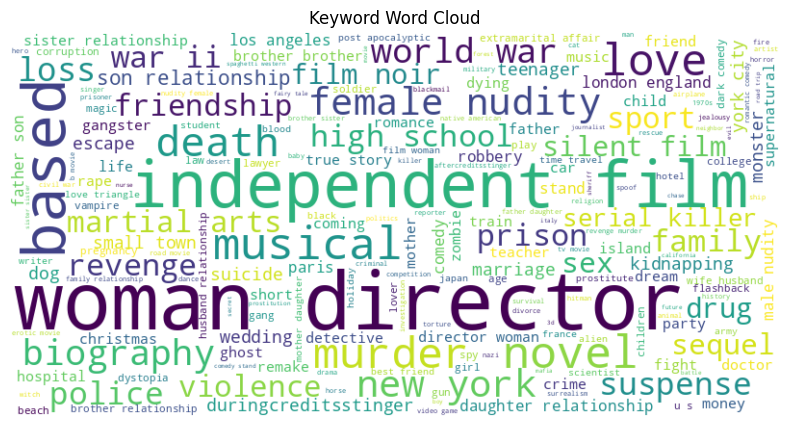

In [ ]:
# Assuming `df` is your DataFrame with a 'keywords' column

# Combine all keywords into one large string
# First, convert 'keywords' column to lists of strings if they are stored as dictionary lists
keywords_combined = " ".join(
    " ".join([kw['name'] for kw in ast.literal_eval(keywords) if 'name' in kw])
    for keywords in df5['keywords'].dropna()
)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(keywords_combined)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Keyword Word Cloud")
plt.show()

In [ ]:
# Step 1: Preprocess Keywords
# Combine keywords into a single string per movie
df5['keywords_text'] = df5['keywords'].dropna().apply(lambda x: " ".join([kw['name'] for kw in ast.literal_eval(x) if 'name' in kw]))

# Step 2: Vectorize the Keywords Text
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df5['keywords_text'].dropna())

# Step 3: Apply LDA
n_topics = 5  # Set the number of topics
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda.fit(dtm)

# Step 4: Display Topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[-no_top_words:][::-1]]))
        print("\n")

no_top_words = 10  # Set the number of top words to display per topic
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic #1:
film car noir music biography silent robbery christmas rock bank


Topic #2:
murder based novel nudity police violence killer revenge female musical


Topic #3:
comedy drug monster stand animal duringcreditsstinger gay horror dark giant


Topic #4:
film independent war world nudity alien space sex ii suspense


Topic #5:
woman director relationship love family father school new sport mother




## 1.2 Now, let's do our recommendations based on user-user, item-item and Matrix Factorization techniques using Model implementations but here, we'll be using downsampling (using 20% of the data) then batch processing to make sure the ram doesn't crash.

In [ ]:
# Downsample the data to 10% of the original size
downsampled_df = data.sample(frac=0.5, random_state=1001)

# Check the size of the downsampled dataset
print(f"Downsampled dataset size: {downsampled_df.shape}",downsampled_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5729450 entries, 7483895 to 4715614
Data columns (total 32 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   cast                   object 
 1   crew                   object 
 2   id                     int64  
 3   adult                  object 
 4   belongs_to_collection  object 
 5   budget                 object 
 6   genres                 object 
 7   homepage               object 
 8   imdb_id                object 
 9   original_language      object 
 10  original_title         object 
 11  overview               object 
 12  popularity             object 
 13  poster_path            object 
 14  production_companies   object 
 15  production_countries   object 
 16  release_date           object 
 17  revenue                float64
 18  runtime                float64
 19  spoken_languages       object 
 20  status                 object 
 21  tagline                object 
 22  title            

In [ ]:
# Define batch size, e.g., 10,000 rows at a time (I've done it 1.5k at the time as the ram didn't crash.)
batch_size = 1500

# Reader for Surprise with the downsampled data's rating range
reader = Reader(rating_scale=(downsampled_df['rating'].min(), downsampled_df['rating'].max()))

# Initialize user-user collaborative filtering model
#sim_options = {'name': 'cosine', 'user_based': False} #user-based is true if the user wants user-user interactions and false if item item
model = SlopeOne()
#---User-User
#KNNBasic = 0.6764
#KNNWithMeans = 0.0656----192.69 seconds
#KNNWithZScore = 0.0735
#---Item-Item
#KNNWithZScore = 0.0667
#KNNWithMeans = 0.0618----62.32 seconds
#KNNBasic = 0.1038
#---Model Based
#SVD = 0.7047
#CoClustering = 0.8093
#NMF = 0.1739----Also, 148.05 Seconds
#SlopeOne = 0.0210 best so far #71.48 seconds
#BaselineOnly = 0.9077
#SVDpp = 0.7243

# List to collect predictions across all batches
all_predictions = []

In [ ]:
# Calculate the number of batches needed
num_batches = len(downsampled_df) // batch_size + (1 if len(downsampled_df) % batch_size != 0 else 0)
total_time = 0

for i in range(num_batches):
    # Define start and end index for the batch
    start = i * batch_size
    end = start + batch_size

    # Get a batch from the downsampled DataFrame
    batch_df = downsampled_df.iloc[start:end][['userId', 'id', 'rating']]

    # Convert batch to Surprise dataset format
    data_batch = Dataset.load_from_df(batch_df, reader)
    trainset = data_batch.build_full_trainset()

    # Record start time
    start_time = time.time()

    # Train the model on the current batch
    model.fit(trainset)

    # Record end time
    end_time = time.time()

    runtime = end_time - start_time

    total_time += runtime

    # Create test set for predictions (using the same batch as test set for simplicity)
    testset = trainset.build_testset()
    predictions = model.test(testset)

    # Collect predictions
    all_predictions.extend(predictions)

print(f"Total training time across all batches: {total_time:.2f} seconds")

Total training time across all batches: 71.48 seconds


In [ ]:
#Root mean squared error
rmse = accuracy.rmse(all_predictions)
print(f"RMSE across all batches (downsampled): {rmse}")

RMSE: 0.0657
RMSE across all batches (downsampled): 0.06571779007273632


**RMSE** measures the average difference between values predicted by a model and the actual values. It provides an estimation of how well the model is able to predict the target value (accuracy). The lower the value of the Root Mean Squared Error, the better the model is.

In [ ]:
scattter_data = pd.read_csv('/content/drive/MyDrive/algorithm_values.csv')
scattter_data

,Algorithm,Type,Value
0,KNNBasic,User-User,0.6764
1,KNNWithMeans,User-User,0.0656
2,KNNWithZScore,User-User,0.0735
3,KNNWithZScore,Item-Item,0.0667
4,KNNWithMeans,Item-Item,0.0618
5,KNNBasic,Item-Item,0.1038
6,SVD,Model Based,0.7047
7,CoClustering,Model Based,0.8093
8,NMF,Model Based,0.1739
9,SlopeOne,Model Based,0.0210


<ipython-input-34-aa6a6b82483a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(scattter_data, x='Value', y='Type', inner='stick', palette='Dark2')


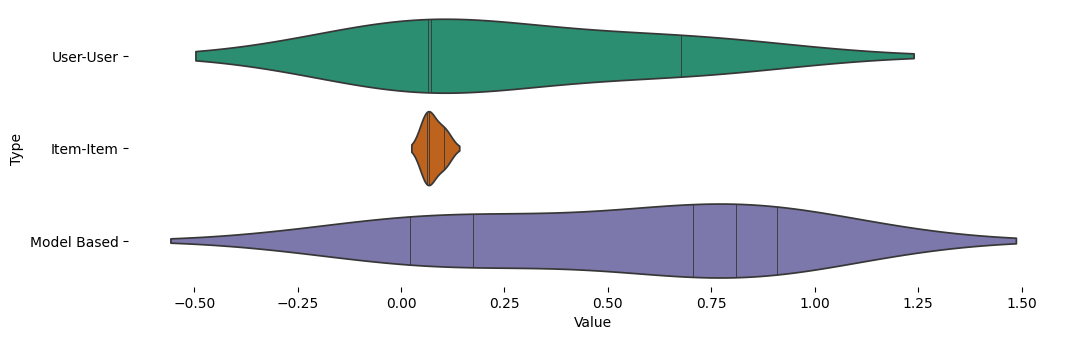

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(scattter_data['Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(scattter_data, x='Value', y='Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## 1.3 Item based collaborative filtering works the best as of now for Pandas.

# Step 2: Now, without downsampling the data, we use collaborative filtering with Spark.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS

spark = SparkSession.builder \
    .appName("UserUserCF") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

# Assuming 'df' is your dataset in a Pandas DataFrame format
# Convert it to a Spark DataFrame
spark_df = spark.createDataFrame(data[['userId', 'id', 'rating']])

# Show schema to confirm successful load
spark_df.printSchema()

root
 |-- userId: long (nullable = true)
 |-- id: long (nullable = true)
 |-- rating: double (nullable = true)



In [ ]:
ratings_df = spark_df.select("userId", "id", "rating") \
                     .withColumn("userId", spark_df["userId"].cast("integer")) \
                     .withColumn("movieId", spark_df["id"].cast("integer")) \
                     .withColumn("rating", spark_df["rating"].cast("float"))

In [ ]:
# Split the data
train_df, test_df = ratings_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
total_time_spark = 0
# Configure ALS for user-user CF
als = ALS(maxIter=10, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

start_time = time.time()
# Train ALS model
als_model = als.fit(train_df)
end_time = time.time()
total_time_spark += (end_time - start_time)
print(f"Training time: {total_time_spark:.2f} seconds")

Training time: 264.85 seconds


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions
predictions = als_model.transform(test_df)

# Evaluate RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error (RMSE): {rmse}")

Root-mean-square error (RMSE): 0.8386857520432024


In [ ]:
user_id = 900
item_id = 46
pred = model.predict(user_id, item_id)
print(f"Prediction for user {user_id} on item {item_id}: {pred.est}")

NameError: name 'model' is not defined

In [ ]:
# prompt: want to make a dataframe of 4 values: KNNWithMeans = 192.69 seconds KNNWithMeans = 62.32 second SlopeOne =  71.48 seconds, ALS = 264.85 seconds

import pandas as pd

data = {'Algorithm': ['KNNWithMeans', 'KNNWithMeans', 'SlopeOne', 'ALS'],
        'Time (seconds)': [192.69, 62.32, 71.48, 264.85]}
df = pd.DataFrame(data)
df

,Algorithm,Time (seconds)
0,KNNWithMeans,192.69
1,KNNWithMeans,62.32
2,SlopeOne,71.48
3,ALS,264.85


from matplotlib import pyplot as plt
df['Time (seconds)'].plot(kind='hist', bins=20, title='Time (seconds)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Algorithm').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Time (seconds)']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Time (seconds)'}, axis=1)
              .sort_values('Time (seconds)', ascending=True))
  xs = counted['Time (seconds)']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Time (seconds)', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Algorithm')):
  _plot_series(series, series_name, i)
  fig.legend(title='Algorithm', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time (seconds)')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df['Time (seconds)'].plot(kind='line', figsize=(8, 4), title='Time (seconds)')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Algorithm'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Time (seconds)', y='Algorithm', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

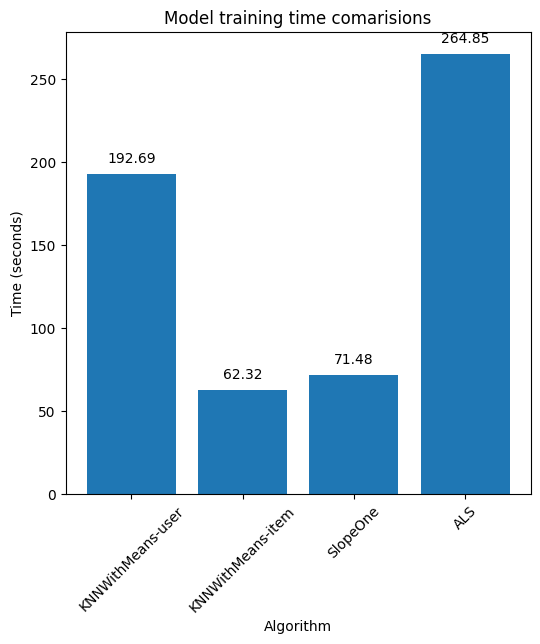

In [ ]:
# prompt: for df, I need a graph with title and labels for 4 values

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with the necessary columns
# Replace with your actual DataFrame

# Sample data (replace with your actual data)
data = {'Algorithm': ['KNNWithMeans-user', 'KNNWithMeans-item', 'SlopeOne', 'ALS'],
        'Time (seconds)': [192.69, 62.32, 71.48, 264.85]}
df = pd.DataFrame(data)


# Create the bar plot
plt.figure(figsize=(6, 6))
plt.bar(df['Algorithm'], df['Time (seconds)'])


# Add title and labels
plt.title('Model training time comarisions')
plt.xlabel('Algorithm')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
# Add value labels on top of each bar
for i, v in enumerate(df['Time (seconds)']):
    plt.text(i, v + 5, str(round(v, 2)), ha='center', va='bottom')  # Adjust 5 as needed

# Show the plot
plt.show()